In [47]:
!pip install mesa


# 📦 Genetic Scheduling with Mesa + Genetic Algorithm

This document explains how the provided Python code uses a **Genetic Algorithm (GA)** to assign jobs to workers (agents in a Mesa simulation) so that a custom **objective value** is minimized. After finding a good assignment, the simulation runs to process jobs over time while tracking progress.

---

## 1) Configuration & Hyperparameters

- **Simulation constants**
  - `SIMULATION_STEPS = 100`: number of time steps to simulate.
  - `MODEL_SEED = 42`: random seed for reproducibility.
  - `MAX_JOB_LENGTH = 67`: maximum possible job size.
  - `JOB_COUNT = 30`: total number of jobs to assign.
  - `WORKER_COUNT = 5`: number of workers (agents).

- **Genetic Algorithm hyperparameters**
  - `POP_SIZE = 80`: population size (number of candidate solutions).
  - `GENERATIONS = 200`: number of evolution iterations.
  - `ELITE_COUNT = 2`: top individuals copied unchanged to the next generation.
  - `TOURNAMENT_K = 3`: size of tournament for parent selection.
  - `CROSSOVER_RATE = 0.9`: probability of applying crossover to selected parents.
  - `MUTATION_RATE = 0.05`: per-gene mutation probability (each job’s assignment may change worker).

---

## 2) Objective & Solution Evaluation

- **`objective(worker, jobs)`**  
  Computes a worker’s contribution to the total objective:  
  `int(sum(jobs) / worker.SALARY)` (heavier loads on higher-salary workers are “cheaper”).  
  If `SALARY` were zero (it isn’t here), it falls back to `int(sum(jobs))`.

- **`evaluate_solution(workers, JOB_LIST)`**  
  Adds up `objective(...)` across all workers. This is the **fitness** value the GA **minimizes**.

---

## 3) Representation (Chromosome) & Decoding

- **Chromosome (`assignments`)**: a list of length `JOB_COUNT`.  
  Each gene is an integer in `[0, WORKER_COUNT - 1]` indicating **which worker** gets that job.

- **`decode_to_joblist(assignments, jobs)`**  
  Converts `assignments` into `JOB_LIST` (list of lists), where `JOB_LIST[i]` contains the job sizes assigned to worker `i`.

- **`evaluate_chromosome(workers, jobs, assignments)`**  
  Decodes the chromosome and evaluates it with `evaluate_solution`.

---

## 4) GA Operators

- **Selection — `tournament_select(population, objectives, k)`**  
  Randomly picks `k` individuals and returns the one with the **lowest** (best) objective.

- **Crossover — `crossover_uniform(p1, p2, p=0.5)`**  
  Produces two children by swapping genes independently with probability `p` at each position.

- **Mutation — `mutate(assignments, rate)`**  
  For each gene, with probability `rate`, reassigns the job to a **different** worker (chosen at random).

> Note: If you see `&lt;` in the snippet, that’s HTML for `<`. In the Python source, it should be `<`.

---

## 5) Genetic Algorithm Loop (`genetic_algorithm`)

1. **Initialization**
   - Create a random population of `POP_SIZE` chromosomes.
   - Evaluate all individuals.
   - Track the global best individual and its objective.

2. **Per-generation metrics (`history`)**
   - `best`: best objective value this generation.
   - `mean`: mean objective of the population.
   - `std`: standard deviation of objectives.
   - `diversity`: ratio of unique individuals to population size.
   - `best_load_std`: standard deviation of per-worker total assigned load for the best individual (a balance proxy).

3. **Elitism**
   - Sort by objective and copy the top `ELITE_COUNT` individuals unchanged.

4. **Breeding**
   - Repeatedly:
     - Select two parents via tournament.
     - With probability `CROSSOVER_RATE`, apply uniform crossover; otherwise copy parents.
     - Mutate both children gene-wise with probability `MUTATION_RATE`.
     - Add children to the new population until it reaches `POP_SIZE`.

5. **Replacement & Tracking**
   - Replace the old population with the new one.
   - Recompute objectives.
   - Update the global best when improved.

6. **Result**
   - Decode the global best chromosome to `best_job_list`.
   - Return `(best_job_list, best_obj, history)`.

---

## 6) Mesa Agents & Simulation

### `Worker` (Agent)
- **State**
  - `JOBS`: a queue (list) of remaining job lengths.
  - `SALARY`: random integer in `[1, 3]`.
- **Step**
  - If there’s a job, reduce the first job by `SALARY`.
  - If it hits `<= 0`, remove it (job completed).

### `WareHouse` (Model)
- **Initialization**
  - Create a random `JOB_LIST` of `JOB_COUNT` jobs with sizes in `[0, MAX_JOB_LENGTH]`.
  - Create `WORKER_COUNT` workers.
  - Run the GA to get `best_job_list`; assign jobs to workers.
  - Store `best_obj_value` and `ga_history`.
  - Initialize simulation tracking (`step_history`) and take an initial snapshot.

- **`_snapshot()`** records per step:
  - `step`: current step counter.
  - `jobs_remaining_count`: total count of queued jobs across workers.
  - `total_work_remaining`: sum of all remaining job lengths.
  - `completed_this_step`: number of jobs completed since the last snapshot.
  - `per_worker_queue_lengths`: queue length for each worker.
  - Updates `_prev_jobs_count` for the next step.

- **`step()`**
  - Advance every worker by one step.
  - Increment the model step.
  - Take a new snapshot.

---

## 7) Running the Model

**`run_model(steps=SIMULATION_STEPS, seed=MODEL_SEED)`**:
- Seed the RNG, instantiate `WareHouse` (which runs the GA and assigns jobs),
- Advance the simulation for `steps`,
- Return:
  - `model` (contains `best_obj_value`, `ga_history`, `step_history`),
  - `ga_history` (per-generation GA metrics),
  - `step_history` (per-step simulation metrics).

Usage:
```python
model, ga_hist, step_hist = run_model()
model.best_obj_value  # The best objective found by the GA


In [48]:

import random
import statistics
import mesa

SIMULATION_STEPS = 100
MODEL_SEED = 42
MAX_JOB_LENGTH = 67
JOB_COUNT = 30
WORKER_COUNT = 5

POP_SIZE = 80
GENERATIONS = 200
ELITE_COUNT = 2
TOURNAMENT_K = 3
CROSSOVER_RATE = 0.9
MUTATION_RATE = 0.05

def objective(worker, jobs):
    return int(sum(jobs) / worker.SALARY) if worker.SALARY else int(sum(jobs))

def evaluate_solution(workers, JOB_LIST):
    return sum(objective(workers[i], JOB_LIST[i]) for i in range(WORKER_COUNT))

def decode_to_joblist(assignments, jobs):
    job_list = [[] for _ in range(WORKER_COUNT)]
    for j_idx, worker_idx in enumerate(assignments):
        job_list[worker_idx].append(jobs[j_idx])
    return job_list

def evaluate_chromosome(workers, jobs, assignments):
    return evaluate_solution(workers, decode_to_joblist(assignments, jobs))

def tournament_select(population, objectives, k=TOURNAMENT_K):
    idxs = random.sample(range(len(population)), k)
    best = min(idxs, key=lambda i: objectives[i])
    return population[best][:]

def crossover_uniform(p1, p2, p=0.5):
    c1, c2 = p1[:], p2[:]
    for i in range(len(p1)):
        if random.random() < p:
            c1[i], c2[i] = c2[i], c1[i]
    return c1, c2

def mutate(assignments, rate=MUTATION_RATE):
    for i in range(len(assignments)):
        if random.random() < rate:
            cur = assignments[i]
            choices = list(range(WORKER_COUNT))
            choices.remove(cur)
            assignments[i] = random.choice(choices)
    return assignments

def genetic_algorithm(workers, jobs):
    n_jobs = len(jobs)
    population = [[random.randint(0, WORKER_COUNT - 1) for _ in range(n_jobs)] for _ in range(POP_SIZE)]
    objectives = [evaluate_chromosome(workers, jobs, ind) for ind in population]
    best_idx = min(range(POP_SIZE), key=lambda i: objectives[i])
    best_obj = objectives[best_idx]
    best_ind = population[best_idx][:]
    history = {"gen": [], "best": [], "mean": [], "std": [], "diversity": [], "best_load_std": []}

    for gen in range(GENERATIONS):
        mean_val = statistics.fmean(objectives)
        std_val = statistics.pstdev(objectives) if len(objectives) > 1 else 0.0
        diversity = len({tuple(ind) for ind in population}) / len(population)

        gen_best_idx = min(range(POP_SIZE), key=lambda i: objectives[i])
        gen_best_obj = objectives[gen_best_idx]
        gen_best = population[gen_best_idx][:]
        gen_best_loads = list(map(sum, decode_to_joblist(gen_best, jobs)))
        gen_best_load_std = statistics.pstdev(gen_best_loads) if len(gen_best_loads) > 1 else 0.0

        history["gen"].append(gen)
        history["best"].append(gen_best_obj)
        history["mean"].append(mean_val)
        history["std"].append(std_val)
        history["diversity"].append(diversity)
        history["best_load_std"].append(gen_best_load_std)

        if gen_best_obj < best_obj:
            best_obj = gen_best_obj
            best_ind = gen_best[:]

        ranked = sorted(zip(population, objectives), key=lambda x: x[1])
        new_population = [ind[:] for ind, _ in ranked[:ELITE_COUNT]]

        while len(new_population) < POP_SIZE:
            p1 = tournament_select(population, objectives, TOURNAMENT_K)
            p2 = tournament_select(population, objectives, TOURNAMENT_K)
            if random.random() < CROSSOVER_RATE:
                c1, c2 = crossover_uniform(p1, p2, p=0.5)
            else:
                c1, c2 = p1[:], p2[:]
            c1 = mutate(c1, MUTATION_RATE)
            c2 = mutate(c2, MUTATION_RATE)
            new_population.append(c1)
            if len(new_population) < POP_SIZE:
                new_population.append(c2)

        population = new_population
        objectives = [evaluate_chromosome(workers, jobs, ind) for ind in population]

    best_job_list = decode_to_joblist(best_ind, jobs)
    return best_job_list, best_obj, history

class Worker(mesa.Agent):
    def __init__(self, unique_id: int, model: mesa.Model):
        super().__init__(model)
        self.unique_id = unique_id
        self.JOBS = []
        self.SALARY = random.randint(1, 3)

    def step(self):
        if self.JOBS:
            self.JOBS[0] -= self.SALARY
            if self.JOBS[0] <= 0:
                self.JOBS.pop(0)

class WareHouse(mesa.Model):
    def __init__(self, seed: int | None = None):
        super().__init__(seed=seed)
        self.JOB_LIST = [self.random.randint(0, MAX_JOB_LENGTH) for _ in range(JOB_COUNT)]
        self.WORKERS = [Worker(unique_id=i, model=self) for i in range(WORKER_COUNT)]
        best_job_list, best_obj, ga_history = genetic_algorithm(self.WORKERS, self.JOB_LIST)
        for i, w in enumerate(self.WORKERS):
            w.JOBS = best_job_list[i]
        self.best_obj_value = best_obj
        self.ga_history = ga_history
        self.step_history = []
        self._cur_step = 0
        self._prev_jobs_count = sum(len(w.JOBS) for w in self.WORKERS)
        self._snapshot()

    def _snapshot(self):
        jobs_remaining_count = sum(len(w.JOBS) for w in self.WORKERS)
        total_work_remaining = sum(sum(w.JOBS) for w in self.WORKERS)
        per_worker_queue_lengths = [len(w.JOBS) for w in self.WORKERS]
        completed_this_step = max(0, self._prev_jobs_count - jobs_remaining_count)
        self.step_history.append({
            "step": self._cur_step,
            "jobs_remaining_count": jobs_remaining_count,
            "total_work_remaining": total_work_remaining,
            "completed_this_step": completed_this_step,
            "per_worker_queue_lengths": per_worker_queue_lengths
        })
        self._prev_jobs_count = jobs_remaining_count

    def step(self):
        for w in self.WORKERS:
            w.step()
        self._cur_step += 1
        self._snapshot()

def run_model(steps=SIMULATION_STEPS, seed=MODEL_SEED):
    random.seed(seed)
    model = WareHouse(seed=seed)
    for _ in range(steps):
        model.step()
    return model, model.ga_history, model.step_history

model, ga_hist, step_hist = run_model()
model.best_obj_value


265

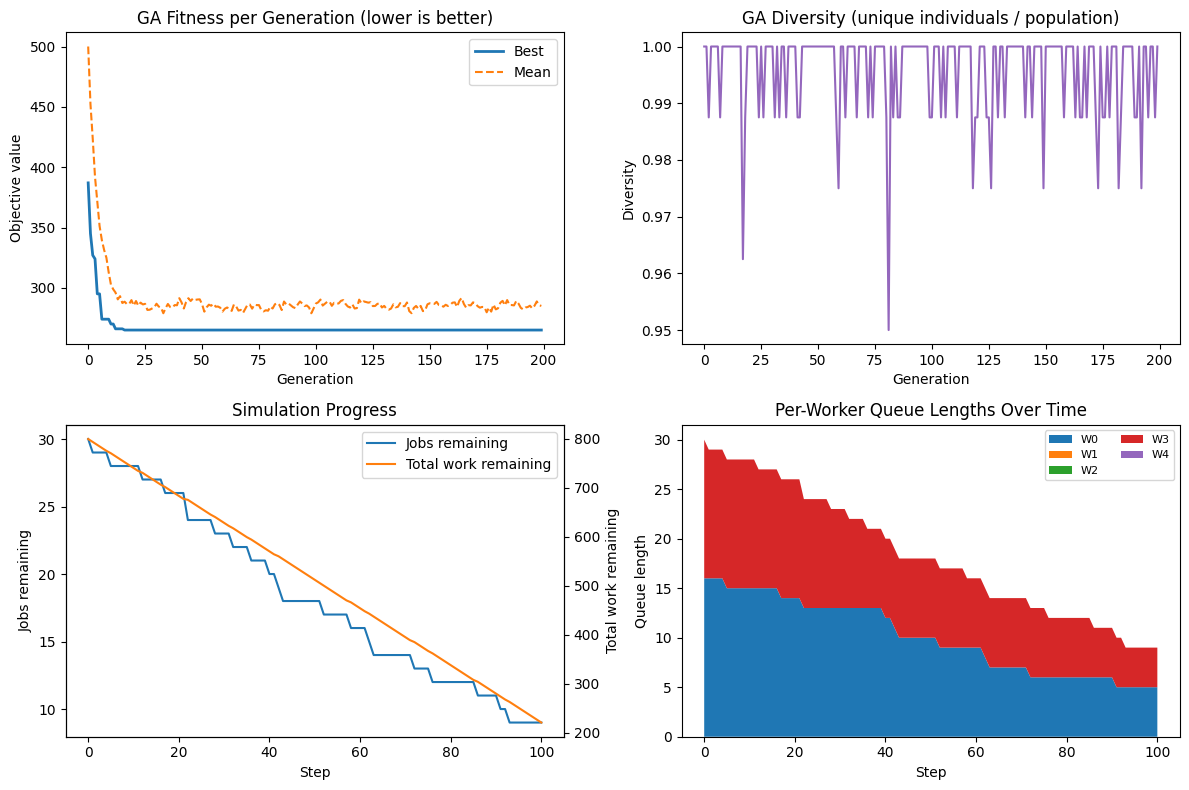

In [49]:

import matplotlib.pyplot as plt

gens = ga_hist["gen"]
best = ga_hist["best"]
mean = ga_hist["mean"]
diversity = ga_hist["diversity"]
best_load_std = ga_hist["best_load_std"]

steps = [d["step"] for d in step_hist]
jobs_remaining = [d["jobs_remaining_count"] for d in step_hist]
total_work_remaining = [d["total_work_remaining"] for d in step_hist]
queue_matrix = [d["per_worker_queue_lengths"] for d in step_hist]
per_worker_series = list(zip(*queue_matrix))  # shape: WORKER_COUNT x time

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

ax = axes[0, 0]
ax.plot(gens, best, label="Best", linewidth=2)
ax.plot(gens, mean, label="Mean", linestyle="--")
ax.set_title("GA Fitness per Generation (lower is better)")
ax.set_xlabel("Generation")
ax.set_ylabel("Objective value")
ax.legend()

ax = axes[0, 1]
ax.plot(gens, diversity, color="tab:purple")
ax.set_title("GA Diversity (unique individuals / population)")
ax.set_xlabel("Generation")
ax.set_ylabel("Diversity")

ax = axes[1, 0]
ax.plot(steps, jobs_remaining, label="Jobs remaining", color="tab:blue")
ax2 = ax.twinx()
ax2.plot(steps, total_work_remaining, label="Total work remaining", color="tab:orange")
ax.set_title("Simulation Progress")
ax.set_xlabel("Step")
ax.set_ylabel("Jobs remaining")
ax2.set_ylabel("Total work remaining")
lns = ax.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lns]
ax.legend(lns, labels, loc="upper right")

ax = axes[1, 1]
ax.stackplot(steps, *per_worker_series, labels=[f"W{i}" for i in range(len(per_worker_series))])
ax.set_title("Per-Worker Queue Lengths Over Time")
ax.set_xlabel("Step")
ax.set_ylabel("Queue length")
ax.legend(loc="upper right", ncol=2, fontsize=8)

plt.tight_layout()
plt.show()
